<!-- Notebook Icon Header -->
<p align="center">
  <img src="https://img.icons8.com/fluency/96/artificial-intelligence.png" alt="AI Icon" width="70" style="margin-right: 10px;"/>
  <img src="https://img.icons8.com/emoji/96/sun-emoji.png" alt="Sun Icon" width="70"/>
</p>

<h1 align="center">🌞 SolarStormNet</h1>
<h3 align="center">Multimodal Deep Learning for Solar Storm Classification</h3>

<p align="center">
  <em>Powered by CNN · ResNet50V2 · MobileNetV2 · Late Fusion Ensemble</em>
</p>

## 🧾 Project Overview

This notebook presents a **comprehensive deep learning pipeline** for solar storm recognition using multimodal solar imagery. It integrates **Convolutional Neural Networks (CNN)** with **ResNet50V2** and **MobileNetV2**, combining their strengths into a robust **hybrid ensemble model** for accurate classification of solar magnetic classes.

Designed for both **research and educational purposes**, the notebook includes:
- End-to-end workflow: from **data preprocessing and augmentation** to **model training, evaluation**, and **prediction visualization**.
- Modular structure for easy experimentation with **architectures**, **hyperparameters**, and **training strategies**.
- Capabilities for **real-time predictions** and potential deployment in solar monitoring systems.

With clear visualizations and a user-friendly structure, this notebook serves as a **ready-to-use and extensible solution** for image classification tasks in **solar physics** and beyond. It is easily adaptable for other domains by modifying the dataset and model design, and is fully compatible with both local and cloud-based environments.


🔬 **Purpose**: Classify solar images into Mount Wilson magnetic classes (Alpha, Beta, BetaX) using multimodal image data  
📦 **Input**: Continuum and magnetogram images  
📈 **Output**: Predicted modality and magnetic class  
🧠 **Tech**: TensorFlow, Keras, OpenCV, Pretrained Models

## **1. Importing Required Libraries**

In [70]:
!pip install kaggle
!pip install opendatasets tqdm

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tqdm import tqdm
import opendatasets as od
from tensorflow.keras import layers, applications, callbacks
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
#od.download('https://www.kaggle.com/datasets/djzezev/solar-storm-recognition-dataset')

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
BASE_DIR = "solar-storm-recognition-dataset/project1/project1"

## **2. Data Analysis**

In [5]:
def analyze_data(base_dir, phases, categories):
    data = {}
    for phase in phases:
        data[phase] = {}
        for category in categories:
            path = os.path.join(base_dir, phase, category)
            if phase == "training":
                subcategories = os.listdir(path)
                data[phase][category] = {sub: len(os.listdir(os.path.join(path, sub))) for sub in subcategories}
            else:
                data[phase][category] = len(os.listdir(path))
    return data

categories = analyze_data(BASE_DIR, ["training", "testing"], ["continuum", "magnetogram"])
print("Data Analysis:", categories)

Data Analysis: {'training': {'continuum': {'alpha': 3639, 'beta': 5714, 'betax': 1780}, 'magnetogram': {'alpha': 3639, 'beta': 5714, 'betax': 1780}}, 'testing': {'continuum': 3, 'magnetogram': 3}}


## **3. Data Visualization**

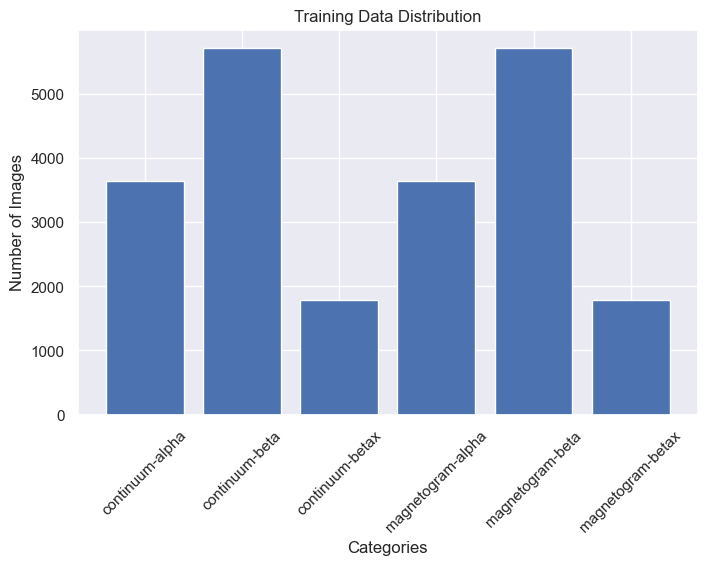

In [6]:
# Data Visualization
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 5))
labels, values = zip(*[(f"{k}-{subk}", v) for k, sub in categories['training'].items() for subk, v in sub.items()])
ax.bar(labels, values)
plt.xticks(rotation=45)
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Training Data Distribution")
plt.show()

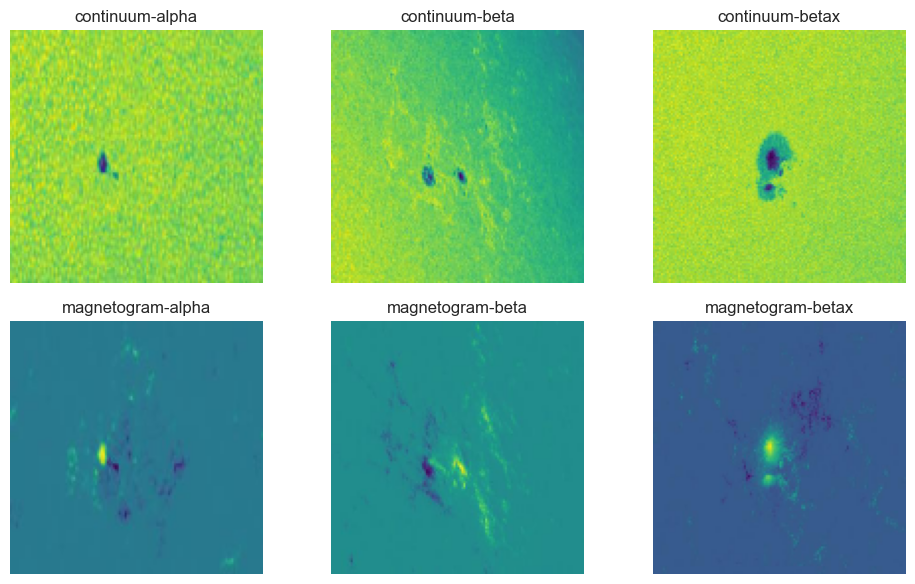

In [7]:
fig, axes = plt.subplots(len(categories['training']), 3, figsize=(10, 6))
for i, (category, subcategories) in enumerate(categories['training'].items()):
    for j, subcategory in enumerate(subcategories.keys()):
        img_path = os.path.join(BASE_DIR, "training", category, subcategory, os.listdir(os.path.join(BASE_DIR, "training", category, subcategory))[0])
        img = load_img(img_path, target_size=(128, 128))
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{category}-{subcategory}")
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()

# **4. Custom Data**

In [8]:
def load_dataset(base_path):
    image_paths = []
    modality_labels = []
    class_labels = []
    
    for modality_idx, modality in enumerate(["continuum", "magnetogram"]):
        modality_path = os.path.join(base_path, modality)
        for class_idx, mag_class in enumerate(["alpha", "beta", "betax"]):
            class_path = os.path.join(modality_path, mag_class)
            for img_name in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_name))
                modality_labels.append(modality_idx)
                class_labels.append(class_idx)
    return image_paths, modality_labels, class_labels

image_paths, modality_labels, class_labels = load_dataset(os.path.join(BASE_DIR, "training"))

# **Split data**

In [50]:
train_paths, val_paths, train_modality, val_modality, train_class, val_class = train_test_split(
    image_paths, modality_labels, class_labels, test_size=0.2, stratify=class_labels, random_state=42
)

## **5. Data Augmentation**

In [10]:
def augment_image(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img

## **6. Data Generators**

In [11]:
def process_image(path, mod_label, cls_label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    if augment:
        img = augment_image(img)
    img = resnet_preprocess(img)
    return img, {"modality_output": tf.one_hot(mod_label, 2), "mag_class_output": tf.one_hot(cls_label, 3)}


In [12]:
def create_dataset(paths, mods, classes, augment=False):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, mods, classes))
    return path_ds.map(lambda p, m, c: process_image(p, m, c, augment)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(train_paths, train_modality, train_class, augment=True)
val_ds = create_dataset(val_paths, val_modality, val_class, augment=False)


# **7. Models Training and Evaluation**

# **Training CNN**

In [13]:
def build_cnn_model():
    input_layer = Input(shape=(*IMG_SIZE, 3), name="input_layer")
    
    # Convolutional layers
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    modality_output = Dense(2, activation="softmax", name="modality_output")(x)
    mag_class_output = Dense(3, activation="softmax", name="mag_class_output")(x)

    model = Model(inputs=input_layer, outputs=[modality_output, mag_class_output])
    model.compile(
        optimizer=Adam(),
        loss={
            "modality_output": "categorical_crossentropy",
            "mag_class_output": "categorical_crossentropy"
        },
        metrics={
            "modality_output": "accuracy",
            "mag_class_output": "accuracy"
        }
    )
    
    return model

cnn_model = build_cnn_model()

In [15]:
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100352)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 12,845,184 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ modality_output     │ (None, 2)         │        258 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mag_class_output    │ (None, 3)         │        387 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,940,485 (49.36 MB)

 Trainable params: 12,939,781 (49.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [18]:
# Callbacks for training    
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("CNN_Classifier.keras", save_best_only=True, monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
    
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the trained CNN model
cnn_model.save("CNN_Classifier.keras")
print("CNN model saved as 'CNN_Classifier.keras'")


Epoch 1/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 325s 582ms/step - loss: 1.0564 - mag_class_output_accuracy: 0.6118 - mag_class_output_loss: 0.9989 - modality_output_accuracy: 0.9842 - modality_output_loss: 0.0576 - val_loss: 0.7029 - val_mag_class_output_accuracy: 0.6843 - val_mag_class_output_loss: 0.6821 - val_modality_output_accuracy: 0.9942 - val_modality_output_loss: 0.0214 - learning_rate: 0.0010
Epoch 2/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 320s 574ms/step - loss: 0.5772 - mag_class_output_accuracy: 0.7712 - mag_class_output_loss: 0.5611 - modality_output_accuracy: 0.9954 - modality_output_loss: 0.0161 - val_loss: 0.9372 - val_mag_class_output_accuracy: 0.5649 - val_mag_class_output_loss: 0.9050 - val_modality_output_accuracy: 0.9969 - val_modality_output_loss: 0.0283 - learning_rate: 0.0010
Epoch 3/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 320s 574ms/step - loss: 0.4668 - mag_class_output_accuracy: 0.8308 - mag_class_output_loss: 0.4443 - modality_output_accuracy: 0.9964 - modality_output_loss: 0.0225

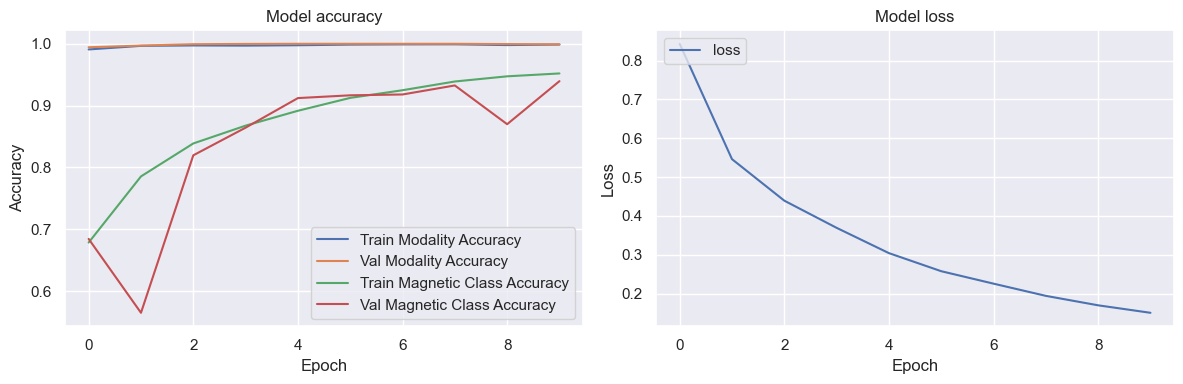

In [24]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(cnn_history.history['modality_output_accuracy'], label='Train Modality Accuracy')
plt.plot(cnn_history.history['val_modality_output_accuracy'], label='Val Modality Accuracy')
plt.plot(cnn_history.history['mag_class_output_accuracy'], label='Train Magnetic Class Accuracy')
plt.plot(cnn_history.history['val_mag_class_output_accuracy'], label='Val Magnetic Class Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# Evaluate the CNN model on the validation dataset
cnn_eval_results = cnn_model.evaluate(val_ds, verbose=1)

# Print evaluation results
print("\nCNN Model Evaluation Results:")
print(f"Loss: {cnn_eval_results[0]:.4f}")
print(f"Modality Accuracy: {cnn_eval_results[3]:.4f}")
print(f"Magnetic Class Accuracy: {cnn_eval_results[4]:.4f}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - loss: 0.1937 - mag_class_output_accuracy: 0.9347 - mag_class_output_loss: 0.1917 - modality_output_accuracy: 0.9998 - modality_output_loss: 0.0019

CNN Model Evaluation Results:
Loss: 0.2006
Modality Accuracy: 0.9324
Magnetic Class Accuracy: 0.9998


# **Training ResNet**

In [25]:
def build_resnet_model():
    base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False  # Freeze the base model

    # Input layer
    input_layer = Input(shape=(*IMG_SIZE, 3), name="input_layer")

    # ResNet base model
    x = base_model(input_layer, training=False)
    x = GlobalAveragePooling2D()(x)

    # Shared dense layers
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layers
    modality_output = Dense(2, activation="softmax", name="modality_output")(x)
    mag_class_output = Dense(3, activation="softmax", name="mag_class_output")(x)

    # Compile the model
    model = Model(inputs=input_layer, outputs=[modality_output, mag_class_output])
    model.compile(
        optimizer=Adam(),
        loss={
            "modality_output": "categorical_crossentropy",
            "mag_class_output": "categorical_crossentropy"
        },
        metrics={
            "modality_output": "accuracy",
            "mag_class_output": "accuracy"
        }
    )
    return model

# Build the ResNet model
resnet_model = build_resnet_model()


In [26]:
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ modality_output     │ (None, 2)         │        258 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mag_class_output    │ (None, 3)         │        387 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,828,229 (90.90 MB)

 Trainable params: 263,173 (1.00 MB)

 Non-trainable params: 23,565,056 (89.89 MB)

In [27]:
# Callbacks for training
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("ResNet_Classifier.keras", save_best_only=True, monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train the ResNet model
resnet_history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the trained ResNet model
resnet_model.save("ResNet_Classifier.keras")
print("ResNet model saved as 'ResNet_Classifier.keras'")

Epoch 1/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 420s 743ms/step - loss: 0.7810 - mag_class_output_accuracy: 0.7144 - mag_class_output_loss: 0.7301 - modality_output_accuracy: 0.9812 - modality_output_loss: 0.0509 - val_loss: 0.3784 - val_mag_class_output_accuracy: 0.8536 - val_mag_class_output_loss: 0.3763 - val_modality_output_accuracy: 0.9998 - val_modality_output_loss: 9.8808e-04 - learning_rate: 0.0010
Epoch 2/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 412s 739ms/step - loss: 0.4374 - mag_class_output_accuracy: 0.8264 - mag_class_output_loss: 0.4327 - modality_output_accuracy: 0.9993 - modality_output_loss: 0.0047 - val_loss: 0.3729 - val_mag_class_output_accuracy: 0.8507 - val_mag_class_output_loss: 0.3709 - val_modality_output_accuracy: 0.9998 - val_modality_output_loss: 4.6818e-04 - learning_rate: 0.0010
Epoch 3/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 409s 734ms/step - loss: 0.3990 - mag_class_output_accuracy: 0.8391 - mag_class_output_loss: 0.3962 - modality_output_accuracy: 0.9996 - modality_output_loss

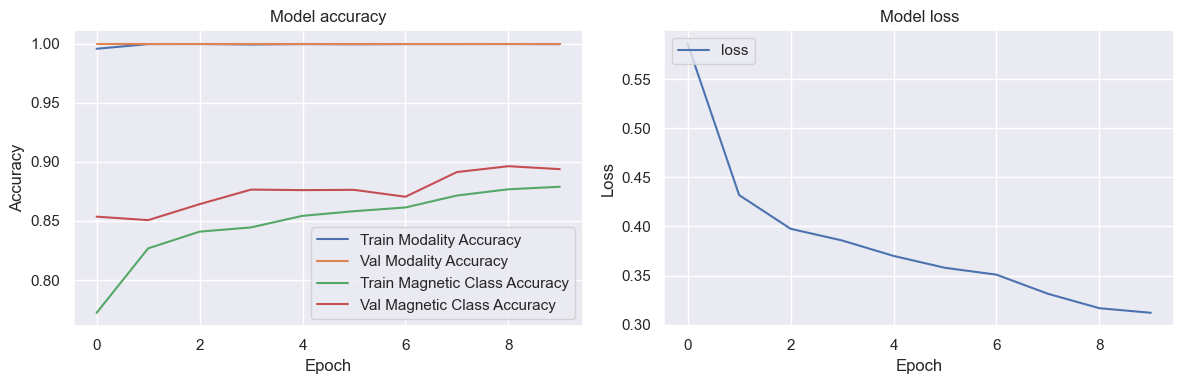

In [28]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(resnet_history.history['modality_output_accuracy'], label='Train Modality Accuracy')
plt.plot(resnet_history.history['val_modality_output_accuracy'], label='Val Modality Accuracy')
plt.plot(resnet_history.history['mag_class_output_accuracy'], label='Train Magnetic Class Accuracy')
plt.plot(resnet_history.history['val_mag_class_output_accuracy'], label='Val Magnetic Class Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# Evaluate the ResNet model on the validation dataset
resnet_eval_results = resnet_model.evaluate(val_ds, verbose=1)
# Print evaluation results
print("\nResNet Model Evaluation Results:")
print(f"Loss: {resnet_eval_results[0]:.4f}")
print(f"Modality Accuracy: {resnet_eval_results[3]:.4f}")
print(f"Magnetic Class Accuracy: {resnet_eval_results[4]:.4f}")


140/140 ━━━━━━━━━━━━━━━━━━━━ 86s 616ms/step - loss: 0.2543 - mag_class_output_accuracy: 0.8996 - mag_class_output_loss: 0.2541 - modality_output_accuracy: 0.9999 - modality_output_loss: 2.0108e-04

ResNet Model Evaluation Results:
Loss: 0.2680
Modality Accuracy: 0.8963
Magnetic Class Accuracy: 0.9998


# **Training MobileNet**

In [31]:
def build_mobilenet_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False  # Freeze the base model

    # Input layer
    input_layer = Input(shape=(*IMG_SIZE, 3), name="input_layer")

    # MobileNet base model
    x = base_model(input_layer, training=False)
    x = GlobalAveragePooling2D()(x)

    # Shared dense layers
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layers
    modality_output = Dense(2, activation="softmax", name="modality_output")(x)
    mag_class_output = Dense(3, activation="softmax", name="mag_class_output")(x)

    # Compile the model
    model = Model(inputs=input_layer, outputs=[modality_output, mag_class_output])
    model.compile(
        optimizer=Adam(),
        loss={
            "modality_output": "categorical_crossentropy",
            "mag_class_output": "categorical_crossentropy"
        },
        metrics={
            "modality_output": "accuracy",
            "mag_class_output": "accuracy"
        }
    )
    return model

# Build the MobileNet model
mobilenet_model = build_mobilenet_model()


In [32]:
mobilenet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    163,968 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ modality_output     │ (None, 2)         │        258 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mag_class_output    │ (None, 3)         │        387 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,423,109 (9.24 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [33]:
# Callbacks for training
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("MobileNet_Classifier.keras", save_best_only=True, monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Train the MobileNet model
mobilenet_history = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the trained MobileNet model
mobilenet_model.save("MobileNet_Classifier.keras")
print("MobileNet model saved as 'MobileNet_Classifier.keras'")

Epoch 1/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 285s 504ms/step - loss: 0.7439 - mag_class_output_accuracy: 0.7187 - mag_class_output_loss: 0.7058 - modality_output_accuracy: 0.9888 - modality_output_loss: 0.0382 - val_loss: 0.3880 - val_mag_class_output_accuracy: 0.8469 - val_mag_class_output_loss: 0.3857 - val_modality_output_accuracy: 0.9996 - val_modality_output_loss: 0.0020 - learning_rate: 0.0010
Epoch 2/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 267s 478ms/step - loss: 0.4142 - mag_class_output_accuracy: 0.8373 - mag_class_output_loss: 0.4080 - modality_output_accuracy: 0.9990 - modality_output_loss: 0.0062 - val_loss: 0.3591 - val_mag_class_output_accuracy: 0.8561 - val_mag_class_output_loss: 0.3577 - val_modality_output_accuracy: 0.9996 - val_modality_output_loss: 0.0012 - learning_rate: 0.0010
Epoch 3/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 253s 454ms/step - loss: 0.3797 - mag_class_output_accuracy: 0.8561 - mag_class_output_loss: 0.3747 - modality_output_accuracy: 0.9989 - modality_output_loss: 0.0050

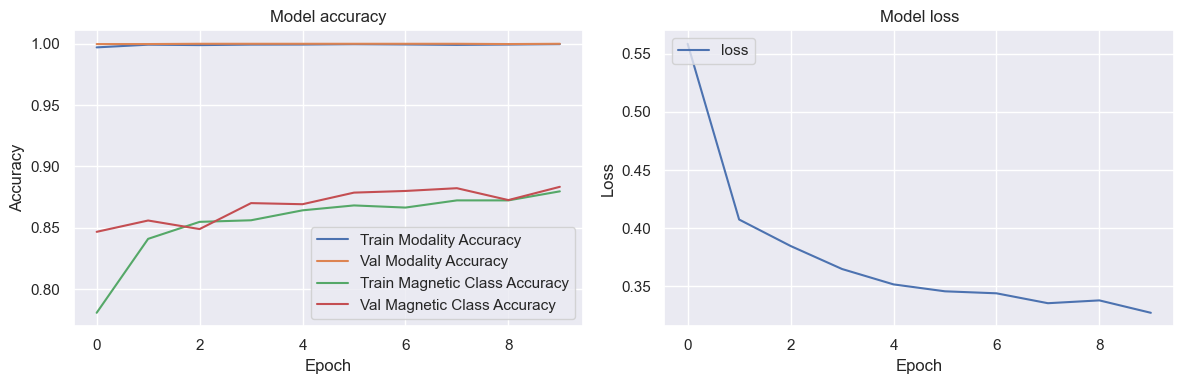

In [34]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(mobilenet_history.history['modality_output_accuracy'], label='Train Modality Accuracy')
plt.plot(mobilenet_history.history['val_modality_output_accuracy'], label='Val Modality Accuracy')
plt.plot(mobilenet_history.history['mag_class_output_accuracy'], label='Train Magnetic Class Accuracy')
plt.plot(mobilenet_history.history['val_mag_class_output_accuracy'], label='Val Magnetic Class Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(mobilenet_history.history['loss'], label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
# Evaluate the MobileNet model on the validation dataset
mobilenet_eval_results = mobilenet_model.evaluate(val_ds, verbose=1)   
# Print evaluation results
print("\nMobileNet Model Evaluation Results:")
print(f"Loss: {mobilenet_eval_results[0]:.4f}")
print(f"Modality Accuracy: {mobilenet_eval_results[3]:.4f}")
print(f"Magnetic Class Accuracy: {mobilenet_eval_results[4]:.4f}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 347ms/step - loss: 0.2852 - mag_class_output_accuracy: 0.8921 - mag_class_output_loss: 0.2850 - modality_output_accuracy: 0.9999 - modality_output_loss: 2.1586e-04

MobileNet Model Evaluation Results:
Loss: 0.2936
Modality Accuracy: 0.8835
Magnetic Class Accuracy: 0.9998


In [40]:
# Save the training history
pd.DataFrame(cnn_history.history).to_csv("cnn_training_history.csv", index=False)
pd.DataFrame(resnet_history.history).to_csv("resnet_training_history.csv", index=False)
pd.DataFrame(mobilenet_history.history).to_csv("mobilenet_training_history.csv", index=False)

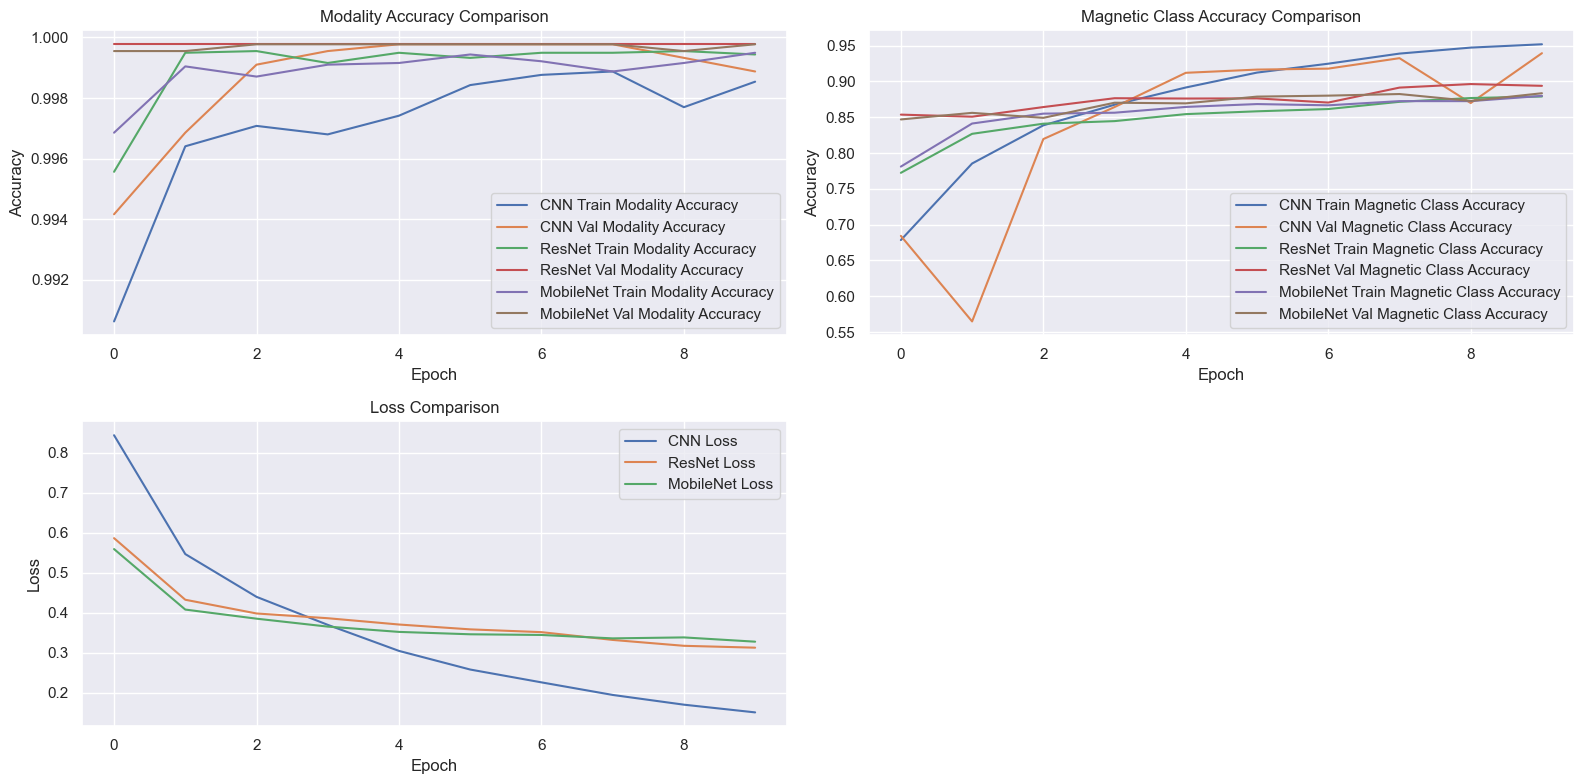

In [45]:
# Plot training history for all models in a single figure
plt.figure(figsize=(16, 8))

# Accuracy comparison
plt.subplot(2, 2, 1)
plt.plot(cnn_history.history['modality_output_accuracy'], label='CNN Train Modality Accuracy')
plt.plot(cnn_history.history['val_modality_output_accuracy'], label='CNN Val Modality Accuracy')
plt.plot(resnet_history.history['modality_output_accuracy'], label='ResNet Train Modality Accuracy')
plt.plot(resnet_history.history['val_modality_output_accuracy'], label='ResNet Val Modality Accuracy')
plt.plot(mobilenet_history.history['modality_output_accuracy'], label='MobileNet Train Modality Accuracy')
plt.plot(mobilenet_history.history['val_modality_output_accuracy'], label='MobileNet Val Modality Accuracy')
plt.title('Modality Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(cnn_history.history['mag_class_output_accuracy'], label='CNN Train Magnetic Class Accuracy')
plt.plot(cnn_history.history['val_mag_class_output_accuracy'], label='CNN Val Magnetic Class Accuracy')
plt.plot(resnet_history.history['mag_class_output_accuracy'], label='ResNet Train Magnetic Class Accuracy')
plt.plot(resnet_history.history['val_mag_class_output_accuracy'], label='ResNet Val Magnetic Class Accuracy')
plt.plot(mobilenet_history.history['mag_class_output_accuracy'], label='MobileNet Train Magnetic Class Accuracy')
plt.plot(mobilenet_history.history['val_mag_class_output_accuracy'], label='MobileNet Val Magnetic Class Accuracy')
plt.title('Magnetic Class Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss comparison
plt.subplot(2, 2, 3)
plt.plot(cnn_history.history['loss'], label='CNN Loss')
plt.plot(resnet_history.history['loss'], label='ResNet Loss')
plt.plot(mobilenet_history.history['loss'], label='MobileNet Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# **8. Training Hybrid Model (CNN, ResNet, MobileNet)**

In [ ]:
def build_hybrid_model(cnn_model, resnet_model, mobilenet_model):
    # Freeze the base models
    cnn_model.trainable = False
    resnet_model.trainable = False
    mobilenet_model.trainable = False

    # Input layer
    input_layer = Input(shape=(*IMG_SIZE, 3), name="input_layer")

    # Get outputs from each model
    cnn_output = cnn_model(input_layer)
    resnet_output = resnet_model(input_layer)
    mobilenet_output = mobilenet_model(input_layer)

    # Concatenate the outputs
    concatenated = layers.Concatenate()([
        cnn_output[0], cnn_output[1],  # CNN outputs
        resnet_output[0], resnet_output[1],  # ResNet outputs
        mobilenet_output[0], mobilenet_output[1]  # MobileNet outputs
    ])

    # Add dense layers for final predictions
    x = Dense(128, activation="relu")(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Final output layers
    modality_output = Dense(2, activation="softmax", name="modality_output")(x)
    mag_class_output = Dense(3, activation="softmax", name="mag_class_output")(x)

    # Compile the hybrid model
    hybrid_model = Model(inputs=input_layer, outputs=[modality_output, mag_class_output])
    hybrid_model.compile(
        optimizer=Adam(),
        loss={
            "modality_output": "categorical_crossentropy",
            "mag_class_output": "categorical_crossentropy"
        },
        metrics={
            "modality_output": "accuracy",
            "mag_class_output": "accuracy"
        }
    )
    return hybrid_model

# Build the hybrid model
hybrid_model = build_hybrid_model(cnn_model, resnet_model, mobilenet_model)

In [48]:
hybrid_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 2),       │ 12,940,485 │ input_layer[0][0] │
│ (Functional)        │ (None, 3)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ [(None, 2),       │ 23,828,229 │ input_layer[0][0] │
│ (Functional)        │ (None, 3)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ [(None, 2),       │  2,423,109 │ input_layer[0][0] │
│ (Functional)        │ (None, 3)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 15)        │          0 │ functional[0][0], │
│ (Concatenate)       │                   │            │ functional[0][1], │
│                     │                   │            │ functional_1[0][… │
│                     │                   │            │ functional_1[0][… │
│                     │                   │            │ functional_2[0][… │
│                     │                   │            │ functional_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      2,048 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ modality_output     │ (None, 2)         │        258 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mag_class_output    │ (None, 3)         │        387 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,195,028 (149.52 MB)

 Trainable params: 2,949 (11.52 KB)

 Non-trainable params: 39,192,079 (149.51 MB)

In [49]:

# Train the hybrid model
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("Hybrid_Classifier.keras", save_best_only=True, monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

hybrid_history = hybrid_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the trained hybrid model
hybrid_model.save("Hybrid_Classifier.keras")
print("Hybrid model saved as 'Hybrid_Classifier.keras'")

Epoch 1/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 784s 1s/step - loss: 0.4441 - mag_class_output_accuracy: 0.8836 - mag_class_output_loss: 0.3348 - modality_output_accuracy: 0.9539 - modality_output_loss: 0.1094 - val_loss: 0.1430 - val_mag_class_output_accuracy: 0.9558 - val_mag_class_output_loss: 0.1417 - val_modality_output_accuracy: 0.9998 - val_modality_output_loss: 5.8947e-04 - learning_rate: 0.0010
Epoch 2/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 767s 1s/step - loss: 0.1726 - mag_class_output_accuracy: 0.9494 - mag_class_output_loss: 0.1707 - modality_output_accuracy: 0.9997 - modality_output_loss: 0.0018 - val_loss: 0.1419 - val_mag_class_output_accuracy: 0.9567 - val_mag_class_output_loss: 0.1408 - val_modality_output_accuracy: 0.9998 - val_modality_output_loss: 3.4582e-04 - learning_rate: 0.0010
Epoch 3/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 797s 1s/step - loss: 0.1520 - mag_class_output_accuracy: 0.9522 - mag_class_output_loss: 0.1506 - modality_output_accuracy: 0.9998 - modality_output_loss: 0.0014 

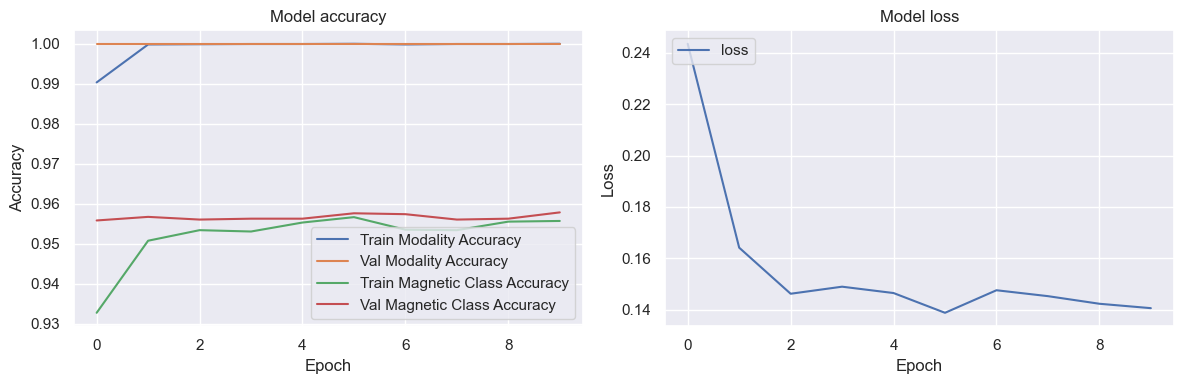

In [51]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hybrid_history.history['modality_output_accuracy'], label='Train Modality Accuracy')
plt.plot(hybrid_history.history['val_modality_output_accuracy'], label='Val Modality Accuracy')
plt.plot(hybrid_history.history['mag_class_output_accuracy'], label='Train Magnetic Class Accuracy')
plt.plot(hybrid_history.history['val_mag_class_output_accuracy'], label='Val Magnetic Class Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(hybrid_history.history['loss'], label='loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# Evaluate the hybrid model on the validation dataset
hybrid_eval_results = hybrid_model.evaluate(val_ds, verbose=1)
# Print evaluation results
print("\nHybrid Model Evaluation Results:")
print(f"Loss: {hybrid_eval_results[0]:.4f}")
print(f"Modality Accuracy: {hybrid_eval_results[3]:.4f}")
print(f"Magnetic Class Accuracy: {hybrid_eval_results[4]:.4f}")
# Save the training history
pd.DataFrame(hybrid_history.history).to_csv("hybrid_training_history.csv", index=False)

140/140 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - loss: 0.1313 - mag_class_output_accuracy: 0.9579 - mag_class_output_loss: 0.1311 - modality_output_accuracy: 0.9999 - modality_output_loss: 2.5150e-04

Hybrid Model Evaluation Results:
Loss: 0.1344
Modality Accuracy: 0.9578
Magnetic Class Accuracy: 0.9998


# **8. Testing Training Model**

In [53]:
# Testing the model using the testing data set 
def load_test_dataset(base_path):
    image_paths = []
    modality_labels = []
    class_labels = []
    
    for modality_idx, modality in enumerate(["continuum", "magnetogram"]):
        modality_path = os.path.join(base_path, modality)
        for class_idx, mag_class in enumerate(["alpha", "beta", "betax"]):
            class_path = os.path.join(modality_path, mag_class)
            for img_name in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_name))
                modality_labels.append(modality_idx)
                class_labels.append(class_idx)
    return image_paths, modality_labels, class_labels

# Testing the model using the testing data set 
test_image_paths, test_modality_labels, test_class_labels = load_test_dataset(os.path.join(BASE_DIR, "testing"))
test_ds = create_dataset(test_image_paths, test_modality_labels, test_class_labels, augment=False)
# Evaluate the hybrid model on the test dataset
hybrid_test_eval_results = hybrid_model.evaluate(test_ds, verbose=1)
# Print evaluation results
print("\nHybrid Model Test Evaluation Results:")
print(f"Loss: {hybrid_test_eval_results[0]:.4f}")
print(f"Modality Accuracy: {hybrid_test_eval_results[3]:.4f}")
print(f"Magnetic Class Accuracy: {hybrid_test_eval_results[4]:.4f}")
# Save the test evaluation results
test_results = pd.DataFrame({
    "Loss": [hybrid_test_eval_results[0]],
    "Modality Accuracy": [hybrid_test_eval_results[3]],
    "Magnetic Class Accuracy": [hybrid_test_eval_results[4]]
})
test_results.to_csv("hybrid_test_results.csv", index=False)



198/198 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - loss: 0.4943 - mag_class_output_accuracy: 0.8573 - mag_class_output_loss: 0.4943 - modality_output_accuracy: 1.0000 - modality_output_loss: 1.1144e-05

Hybrid Model Test Evaluation Results:
Loss: 0.6188
Modality Accuracy: 0.8294
Magnetic Class Accuracy: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96568626..0.9509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9499961..0.9007242].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9353945..0.9271358].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.89968526..0.9276308].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90046346..0.94958925].


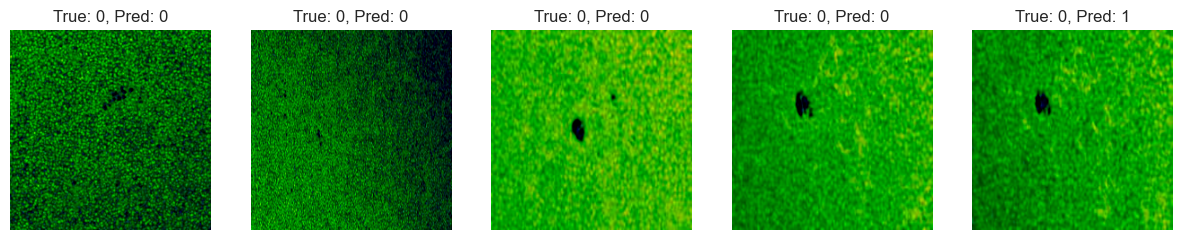

In [ ]:
# Function to visualize model predictions
def visualize_predictions(model, dataset, num_images=5):
    images, labels = [], []
    for img, label in dataset.take(1):
        images.extend(img.numpy())
        labels.extend(label['mag_class_output'].numpy())

    predictions = model.predict(np.array(images))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(f"True: {np.argmax(labels[i])}, Pred: {np.argmax(predictions[1][i])}")
        axes[i].axis("off")
    plt.show()
# Visualize predictions on the test dataset
visualize_predictions(hybrid_model, test_ds, num_images=5)


# **9. Final Predictions**

In [ ]:
def predict(image_path):
    best_model = load_model("Hybrid_Classifier.keras")
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = resnet_preprocess(img)
    img = tf.expand_dims(img, axis=0) 
    predictions = best_model.predict(img, verbose=0)

    modality_pred = np.argmax(predictions[0], axis=-1)[0]
    mag_class_pred = np.argmax(predictions[1], axis=-1)[0]
    modality_conf = np.max(predictions[0], axis=-1)[0]
    mag_class_conf = np.max(predictions[1], axis=-1)[0]
    
    modality_name = 'continuum' if modality_pred == 0 else 'magnetogram'
    mag_class_name = ['alpha', 'beta', 'betax'][mag_class_pred]

    plt.figure(figsize=(8, 6))
    plt.imshow(load_img(image_path))
    plt.title(f"Modality: {modality_name} ({modality_conf:.2%} confident)\n"
        f"Predicted Class: {mag_class_name} ({mag_class_conf:.2%} confident)")
    plt.axis("off")
    plt.show()
    print(f"\nPrediction Results:")
    print(f"=================")
    print(f"Modality: {modality_name}")
    print(f"Confidence: {modality_conf:.2%}")
    print(f"\nMagnetic Class: {mag_class_name}")
    print(f"Confidence: {mag_class_conf:.2%}")

    return {
        "modality": {
            "class": modality_name,
            "confidence": modality_conf
        },
        "magnetic_class": {
            "class": mag_class_name,
            "confidence": mag_class_conf
        }
    }

c:\Users\AHMED\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\AHMED\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


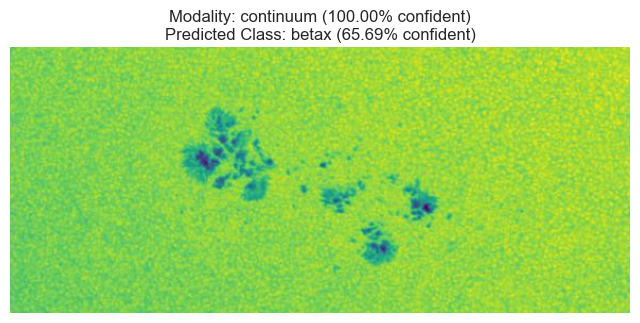


Prediction Results:
Modality: continuum
Confidence: 100.00%

Magnetic Class: betax
Confidence: 65.69%


In [66]:
# Example usage:
image_path = "3bt.jpg"
results = predict(image_path)

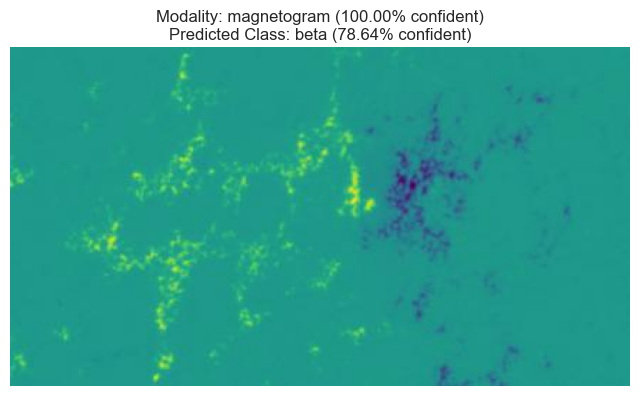


Prediction Results:
Modality: magnetogram
Confidence: 100.00%

Magnetic Class: beta
Confidence: 78.64%


In [67]:
image_path = "Final.jpg"
results = predict(image_path)

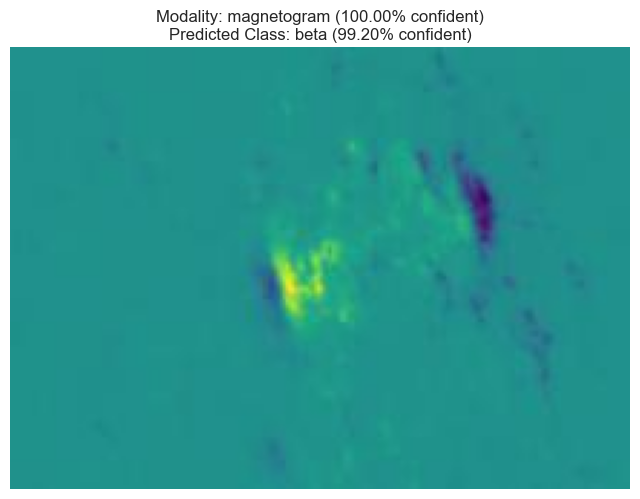


Prediction Results:
Modality: magnetogram
Confidence: 100.00%

Magnetic Class: beta
Confidence: 99.20%


In [68]:
image_path = "2.jpg"
results = predict(image_path)

c:\Users\AHMED\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\AHMED\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


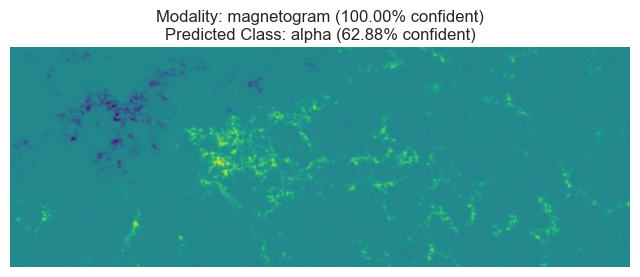


Prediction Results:
Modality: magnetogram
Confidence: 100.00%

Magnetic Class: alpha
Confidence: 62.88%


In [69]:
image_path = "ma.jpg"
results = predict(image_path)